In [87]:
# helper
from graphviz import Digraph

def _trace(root):
    """Collect all nodes and edges reachable from `root`."""
    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.append((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    """
    Render the autograd graph starting at `root`
    (returns a Digraph you can display or save).
    """
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = _trace(root)

    for n in nodes:                                     # node style
        uid = str(id(n))
        label = f"{n.data}"
        if n.operation:
            label += f" | {n.operation}"
        label += f" | ∇={n.grad}"
        dot.node(uid, label=label, shape="record")

    for src, dst in edges:                              # edge style
        dot.edge(str(id(src)), str(id(dst)))

    return dot


In [88]:
class Value():
    def __init__(self, data, operation="", children=[]):
        self.data = data
        self.operation = operation
        self.children = children
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return str(self.data)

    def __add__(self, other):
        result = Value(self.data + other.data, "+", [self, other])
        def _backward():
            self.grad += result.grad
            other.grad += result.grad
        result._backward = _backward
        return result

    def __mul__(self, other):
        result = Value(self.data * other.data, "*", [self, other])
        def _backward():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result._backward = _backward
        return result
    
    def backward(self):
        # A topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.
        # We need this, since we must call backward() on a child strictly after it has been called on its parent
        nodes = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                nodes.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(nodes):
            node._backward()
    

In [89]:
a = Value(10)
b = Value(20)
c = Value(2)
d = a + b
e = d * c
loss = e * Value(0.2)

$$ \frac{\mathrm{dL}}{\mathrm{dL}} = 1.0 $$
$$ \mathrm{L} = 0.2 \mathrm{e} \implies \frac{\mathrm{dL}}{\mathrm{de}} = 0.2 $$
$$ \mathrm{e} = \mathrm{d} \times \mathrm{c} \implies \frac{\mathrm{de}}{\mathrm{dd}} = \mathrm{c} \quad \frac{\mathrm{de}}{\mathrm{dc}} = \mathrm{d} $$
$$ \mathrm{d} = \mathrm{a} + \mathrm{b} \implies \frac{\mathrm{dd}}{\mathrm{da}} = 1 \quad \frac{\mathrm{dd}}{\mathrm{db}} = 1$$

In [90]:
# loss.grad = 1
# e.grad = 0.2 * loss.grad
# d.grad = c.data * e.grad
# c.grad = d.data * e.grad
# a.grad = 1 * d.grad
# b.grad = 1 * d.grad

# loss.grad = 1
# loss.backward()
# e.backward()
# d.backward()

# replaced
loss.grad = 1
loss.backward()

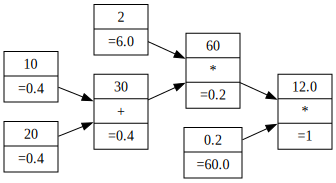

In [91]:
dot = draw_dot(loss)
dot